<a href="https://colab.research.google.com/github/Priestly101/ai_projects/blob/main/Final_Tabular_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# This is my implementation of a decision tree algorithm from scratch.
# I will be using the bulldozers dataset from kaggle.
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz fastai #torch==1.8.0

from fastbook import*

import os
kaggle_data={"username":"priestlyadejo","key":"4c3aae75ae7e170c7603bacd8191faae"}
os.environ['KAGGLE_USERNAME']=kaggle_data["username"]
os.environ['KAGGLE_KEY']=kaggle_data["key"]

from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import*
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import*
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8



     |████████████████████████████████| 727kB 9.2MB/s 
     |████████████████████████████████| 61kB 9.4MB/s 
     |████████████████████████████████| 194kB 18.6MB/s 
     |████████████████████████████████| 1.2MB 11.7MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 61kB 8.6MB/s 
     |████████████████████████████████| 12.8MB 222kB/s 
     |████████████████████████████████| 776.8MB 24kB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.


In [3]:
# Creating a path to download the dataset to.
path = URLs.path('Bulldozers')
path


Path('/root/.fastai/archive/Bulldozers')

In [4]:
Path.BASE_PATH = path

# Getting data using the api
if not path.exists():
  path.mkdir(parents=True)
  api.competition_download_cli('bluebook-for-bulldozers', path=path)
  file_extract(path/'bluebook-for-bulldozers.zip')

# Listsing out the extracted competition directory.
(path).ls(file_type='text')

 10%|█         | 5.00M/48.4M [00:00<00:01, 26.6MB/s]

100%|██████████| 48.4M/48.4M [00:00<00:00, 69.2MB/s]


(#7) [Path('median_benchmark.csv'),Path('Test.csv'),Path('ValidSolution.csv'),Path('Machine_Appendix.csv'),Path('random_forest_benchmark_test.csv'),Path('TrainAndValid.csv'),Path('Valid.csv')]

In [5]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
x = df.columns

# Checking for ordinal variables (Name_of_column:Variables_in_column).
{x[i]:df[f"{c}"].unique() for c,i in zip(x, range(len(x)))}





{'Backhoe_Mounting': array([nan, 'None or Unspecified', 'Yes'], dtype=object),
 'Blade_Extension': array([nan, 'Yes', 'None or Unspecified'], dtype=object),
 'Blade_Type': array([nan, 'PAT', 'None or Unspecified', 'Semi U', 'VPAT', 'Straight', 'Angle', 'No', 'U', 'Landfill', 'Coal'], dtype=object),
 'Blade_Width': array([nan, 'None or Unspecified', "12'", "14'", "13'", "16'", "<12'"], dtype=object),
 'Coupler': array(['None or Unspecified', nan, 'Manual', 'Hydraulic'], dtype=object),
 'Coupler_System': array([nan, 'None or Unspecified', 'Yes'], dtype=object),
 'Differential_Type': array(['Standard', nan, 'Limited Slip', 'No Spin', 'Locking'], dtype=object),
 'Drive_System': array([nan, 'Four Wheel Drive', 'Two Wheel Drive', 'No', 'All Wheel Drive'], dtype=object),
 'Enclosure': array(['EROPS w AC', 'OROPS', 'EROPS', nan, 'EROPS AC', 'NO ROPS', 'None or Unspecified'], dtype=object),
 'Enclosure_Type': array([nan, 'None or Unspecified', 'Low Profile', 'High Profile'], dtype=object),
 'En

In [6]:
# Setting levels for various ordinal categories (Plan to add more after analysis).
# Viewing potential cat vars.
#sizes = df["ProductSize"].unique()

sizes_ordered = 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact'
df['ProductSize'] = df["ProductSize"].astype('category')
df["ProductSize"].cat.set_categories(sizes_ordered, ordered=True, inplace=True)

# Doing log of the sale price as RMSE (Log) is used in the actual competition.
dep_var = "SalePrice"
df[dep_var] = np.log(df[dep_var])

df

,SalesID,SalePrice,MachineID,ModelID,...,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,11.097410,999089,3157,...,NaN,NaN,Standard,Conventional
1,1139248,10.950807,117657,77,...,NaN,NaN,Standard,Conventional
2,1139249,9.210340,434808,7009,...,NaN,NaN,NaN,NaN
3,1139251,10.558414,1026470,332,...,NaN,NaN,NaN,NaN
4,1139253,9.305651,1057373,17311,...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
412693,6333344,9.210340,1919201,21435,...,NaN,NaN,NaN,NaN
412694,6333345,9.259131,1882122,21436,...,NaN,NaN,NaN,NaN
412695,6333347,9.433484,1944213,21435,...,NaN,NaN,NaN,NaN
412696,6333348,9.210340,1794518,21435,...,NaN,NaN,NaN,NaN


In [7]:
# Dates need tp be handled first in our model. Can't be ordinal or continuous as different dates carry differnt meanings.
df = add_datepart(df, "saledate") # Can only be run once

# And the same for the test set.
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

In [8]:
df

"""
sale_meta_df = pd.DataFrame(dict([(key,pd.Series(value)) for key,value in sale_meta.items()]))
sale_meta_df
"""

# Getting all the sale columns
sale = [o for o in df.columns if o.startswith("sale")]
{sale[i]:df[f"{c}"].unique() for c,i in zip(sale, range(len(sale)))}


{'saleDay': array([16, 26, 19, 23, 18, 17, 27,  9, 21, 24, 20,  3, 14, 28, 25, 22,  1, 15,  6,  8, 12, 10,  2, 29, 11,  7,  5,  4, 30, 13, 31]),
 'saleDayofweek': array([3, 4, 1, 2, 0, 6, 5]),
 'saleDayofyear': array([320,  86,  57, 139, 204, 353, 239, 321, 221, 234, 236, 293,  26,   3, 165,  28,  68, 138, 292, 298, 141,  53, 152, 295,  81, 208, 160, 205, 166, 176,  56, 349, 190, 167, 348, 322, 218, 189,
        197, 102,  41,  34, 179, 153, 232, 137, 130, 119, 112,  25, 294, 155,  71, 267, 291,  85, 118, 341, 319,  50, 223, 277,  39,  29, 262, 307, 120,  43, 146, 110, 162,  67, 250,  54, 154, 315,
        207, 113, 106, 235, 263, 340,  64, 308, 124, 217, 123, 178, 126, 209, 311,  82, 181, 171, 193, 169, 195, 249, 306, 188, 265, 233, 125,  96, 180, 222,  38, 344,  20, 237, 253, 194,  11,  91,
        305, 220, 304, 278,  95, 350, 201, 134, 264, 352, 274, 127, 107, 335, 279, 225,  72, 325, 337, 252, 347, 251, 269,  92, 132,   8, 196, 323,  36, 183,  10,  12, 117, 214, 206, 246,  13, 227

In [9]:
# Putting the data into a tabular pandas.
# Procs
procs = [Categorify,FillMissing]

# Creating new validation set so data is more accurate. Splits.
condishyy = (df.saleYear<2011) | (df.saleMonth<10)
train_indexs = np.where(condishyy)[0]
valid_indexs = np.where(~condishyy)[0]
splits = (list(train_indexs), list(valid_indexs))

# cat_cont, max_card is meant to be max_cardinality.
cont, cat = cont_cat_split(df, 1,dep_var=dep_var)

to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)


In [10]:
# Checking the function of the tabular pandas before puttting it into the model
#to.train.cat_names
#to.train.cont_names

to.show(5)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340
3,High,PC120-6E,PC120,#na#,-6E,#na#,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metric Tons",Texas,TEX,Track Excavators,#na#,EROPS w AC,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139251,1026470,332,121,3.0,2001,3486.0,2011,5,20,19,3,139,1.305763e+09,10.558414
4,Medium,S175,S175,#na#,#na#,#na#,#na#,Skid Steer Loader - 1601.0 to 1751.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,EROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139253,1057373,17311,121,3.0,2007,722.0,2009,7,30,23,3,204,1.248307e+09,9.305651


In [11]:
# Check that underlying data has been replaced with continuous levels for the model.
to.items

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,...,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,...,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,...,1,1.077754e+09,1,1
3,1139251,10.558414,1026470,332,...,1,1.305763e+09,1,1
4,1139253,9.305651,1057373,17311,...,1,1.248307e+09,1,1
...,...,...,...,...,...,...,...,...,...
401120,6333336,9.259130,1840702,21439,...,1,1.320192e+09,1,2
401121,6333337,9.305651,1830472,21439,...,1,1.320192e+09,1,2
401122,6333338,9.350102,1887659,21439,...,1,1.320192e+09,1,2
401123,6333341,9.104980,1903570,21435,...,1,1.319501e+09,1,2


In [12]:
# First creating a decision tree.
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

m = DecisionTreeRegressor(criterion="mse", max_leaf_nodes=7).fit(xs, y)


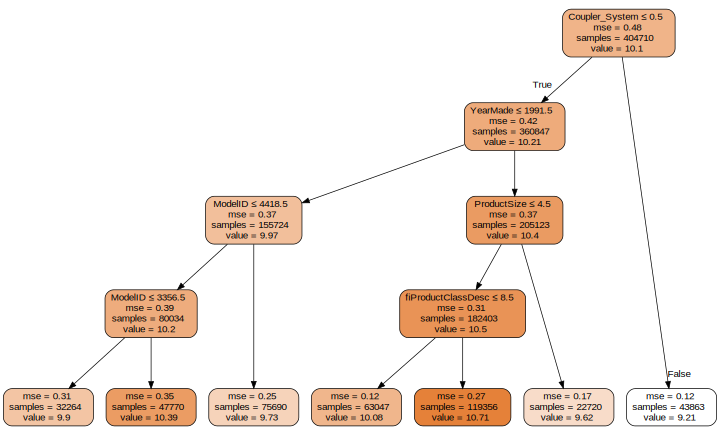

In [13]:
draw_tree(m, xs, precision=2, size=10, leaves_parallel=True)

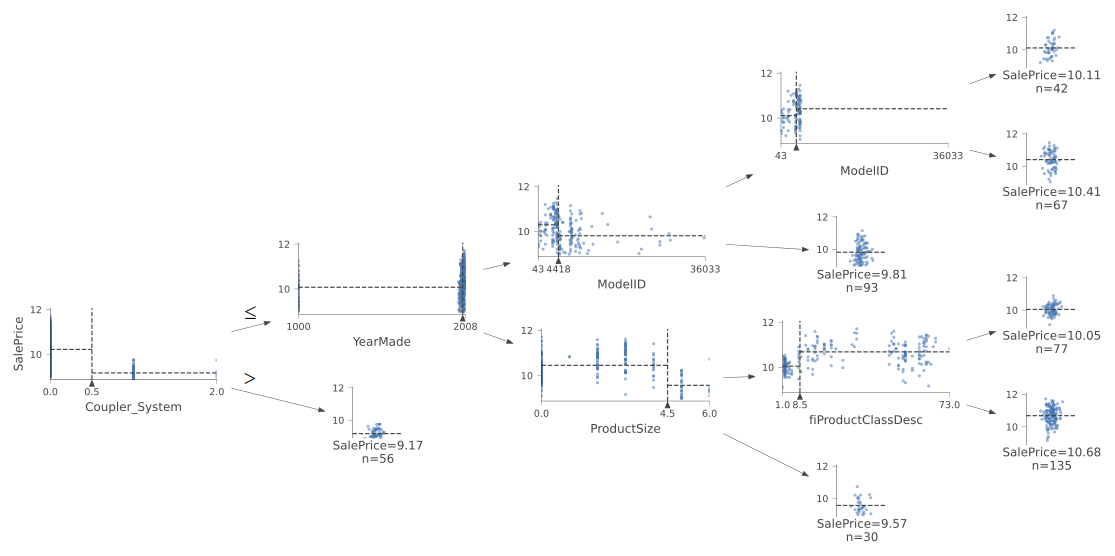

In [14]:
# Using dtreeviz. This doesn't really help with the model, just improves visualisation. Only use a subset of data (or it won't show).
index_permuted = np.random.permutation(len(y))[:500] # Random indexes are sampled.

dtreeviz(m, xs.iloc[index_permuted], y.iloc[index_permuted], xs.columns, dep_var,
         fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
         orientation='LR')

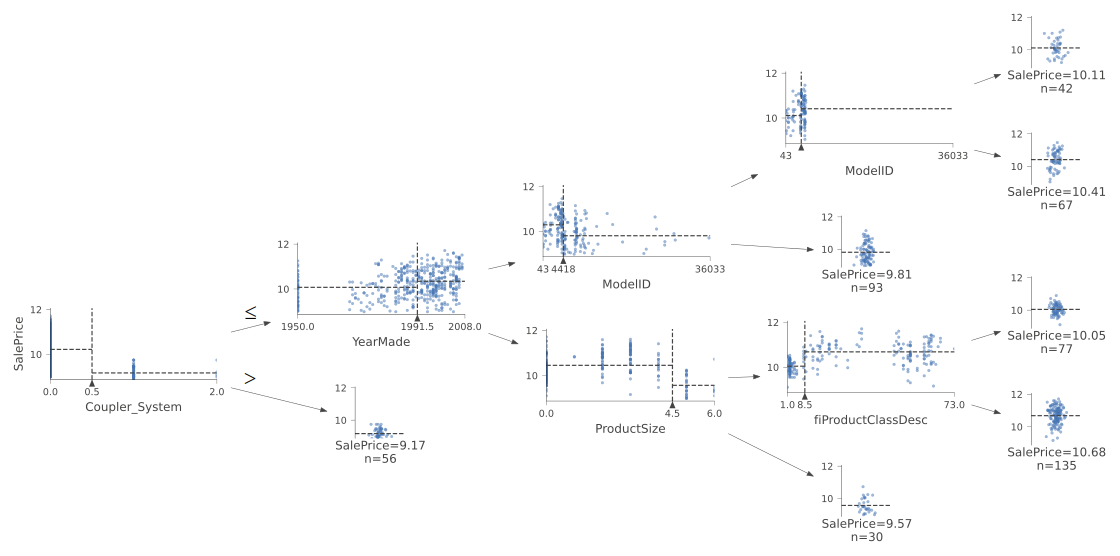

In [15]:
# Sorting out the N/A values in YearMade.
xs.loc[xs["YearMade"]<1900, "YearMade"] = 1950 # Selects "Year Made values<1900 and makes them 1950"
valid_xs.loc[valid_xs["YearMade"]<1900, "YearMade"] = 1950

dtreeviz(m, xs.iloc[index_permuted], y.iloc[index_permuted], xs.columns, dep_var,
         fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
         orientation='LR')

In [16]:
# Recreating DecisionTree model.
m = DecisionTreeRegressor(min_samples_leaf=25).fit(xs, y)


In [17]:
#new_permutation = np.random.permutation(index_permuted)
#draw_tree(m, xs.iloc[new_permutation], size=10, precision=2)
xs.shape, y.shape
index_permuted = np.array(index_permuted).astype(int)
xs.iloc[index_permuted]

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,...,saleDay,saleDayofweek,saleDayofyear,saleElapsed
59694,0,747,245,31,...,17,2,260,1.063757e+09
120492,0,3141,1056,59,...,27,2,270,1.159315e+09
235381,0,3912,1408,0,...,21,1,112,7.038144e+08
50111,0,1076,326,78,...,13,2,347,1.165968e+09
282562,0,4562,1725,0,...,1,5,274,7.809696e+08
...,...,...,...,...,...,...,...,...,...
274293,0,3601,1308,0,...,16,3,321,9.743328e+08
170715,0,494,176,15,...,22,3,265,7.801920e+08
208874,0,3507,1244,0,...,17,0,77,1.205712e+09
268994,0,1410,407,0,...,25,1,85,1.206403e+09


In [18]:
#dtreeviz(m, xs.iloc[index_permuted], y.iloc[index_permuted], xs.columns, dep_var, fontname='DejaVu Sans', scale=1.6, label_fontsize=10)
         #orientation='LR')

In [19]:
# Creating rmse and m_rmse:
def rmse(pred, y): return np.round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(tree, xs, y): return rmse(tree.predict(xs), y)

# Checking errors m:
print(f"Valid RMSLE: {m_rmse(m, valid_xs, valid_y)}\n"
      f"Train RMSLE: {m_rmse(m, xs, y)}\n"
      f"Num_Leaves and Depth : {m.get_n_leaves()} {m.get_depth()}") # Depth is basically the amount/level of descions/splits made from primary node to the leaves.


Valid RMSLE: 0.268865
Train RMSLE: 0.211706
Num_Leaves and Depth : 12400 32


In [20]:
# Now I will train a random forest.
# Random forest function. 

# I will play around with this later and do a for loop exploring different parmeters.
def rf(xs, y, n_estimators=45, max_samples=200000, max_features=0.5, min_samples_leaf=5):
    return RandomForestRegressor(
            n_estimators=n_estimators, n_jobs=-1,
            oob_score=True, max_samples=max_samples,
            max_features=max_features, min_samples_leaf=min_samples_leaf
            ).fit(xs, y)

# Random Forest Model.
m_rf = rf(xs, y)

In [21]:
# Checking errors m_rf:
print(f"Valid RMSLE: {m_rmse(m_rf, valid_xs, valid_y)}\n"
      f"Train RMSLE: {m_rmse(m_rf, xs, y)}\n")

trees = m_rf.estimators_[0:]

len(m_rf.estimators_), trees
#{f"n_leaves and depth for tree {i}": (t[i].get_n_leaves(),t[i].get_depth()) for t,i in zip(trees, range(len(trees)))}

Valid RMSLE: 0.233629
Train RMSLE: 0.170927



(45, [DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                        max_features=0.5, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=5, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=1643543903, splitter='best'),
  DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                        max_features=0.5, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=5, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=1952856546, splitter='best'),
  DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                        max_features=0.5, max_leaf_nodes=None,
                       

In [22]:
# I only stacked the predictions so I could use them to plot the error.
predictions_valid = np.stack([t.predict(valid_xs) for t in m_rf.estimators_])
predictions_train = np.stack([t.predict(xs) for t in m_rf.estimators_])

# Error of random forest (average of error over all trees in forest), to check if stack went well.
print(f"Valid RMSLE: {rmse(predictions_valid.mean(0), valid_y)}\n"
      f"Train RMSLE: {rmse(predictions_train.mean(0), y)}\n")

Valid RMSLE: 0.233629
Train RMSLE: 0.170927



In [23]:
# Taking a look at the splits made for each tree
#[draw_tree(tree[i], xs, precision=3, size=10) for tree,i in zip(m_rf.estimators_, range(len(m_rf.n_estimators)))]
# For some reason I can't iterate over the trees but can index into them.

In [24]:
x = [m_rf.estimators_[i] for i in range(4)]
"""
draw_tree(x[0], xs, precision=3) # It's likely that for high numbers of nodes dtreeviz and draw_tree don't display anything.
# Can only be used on a small subset of leaves in the tree.
"""

"\ndraw_tree(x[0], xs, precision=3) # It's likely that for high numbers of nodes dtreeviz and draw_tree don't display anything.\n# Can only be used on a small subset of leaves in the tree.\n"

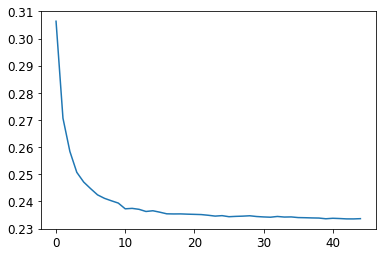

In [25]:
plt.plot([rmse(predictions_valid[:i+1].mean(0), valid_y) for i in range(m_rf.n_estimators)])
# Greater the number of trees the lower the loss.

In [26]:
# Model errors and OOB.
print(f"Valid RMSLE: {m_rmse(m_rf, valid_xs, valid_y)}\n"
      f"Train RMSLE: {m_rmse(m_rf, xs, y)}\n"
      f"OOB Error  : {rmse(m_rf.oob_prediction_, y)}") # OOB error must be calculated on the training set, as its calculated using values that weren't selected for training.

# This function checks to see if oob error is larger than normal ensemble error.
def is_oob_greater(rf, xs, y): 
  rmse_error = m_rmse(rf, xs, y)
  oob_error = rmse(rf.oob_prediction_, y)
  cond = oob_error > rmse_error
  return cond

# Checking cond:
cond = is_oob_greater(m_rf, xs, y)
if cond:
  print("\n\nOOB prediction error is larger than error on training set")
else:
    print("\n\nOOB prediction error is smaller than error on training set")


Valid RMSLE: 0.233629
Train RMSLE: 0.170927
OOB Error  : 0.210509


OOB prediction error is larger than error on training set


In [27]:
# Model Interpretations.

# Using the standard deviation to see distribution of the model.
preds = np.stack([t.predict(valid_xs) for t in m_rf.estimators_])
preds_std = preds.std(0)
preds_std[:10]

array([0.26325102, 0.11219868, 0.11955395, 0.24399146, 0.116944  , 0.3040445 , 0.27080757, 0.26827839, 0.40372759, 0.23033698])

In [28]:
# Getting and plotting the feature importances of a model.
# Tells us how a model is making predictions.

# Function for feature importances.
def rf_feat_imps(m, df):
  feat_dict = pd.DataFrame({"Columns":df.columns,"Feat_Imps":m.feature_importances_}).sort_values("Feat_Imps", ascending=False)
  return feat_dict

fi = rf_feat_imps(m_rf, xs)
# 10 most important features of the model.
fi[:10]


,Columns,Feat_Imps
57,YearMade,0.175932
30,Coupler_System,0.133984
6,ProductSize,0.120687
7,fiProductClassDesc,0.074808
54,ModelID,0.054501
65,saleElapsed,0.049816
3,fiSecondaryDesc,0.045536
31,Grouser_Tracks,0.043097
1,fiModelDesc,0.035084
12,Enclosure,0.031458


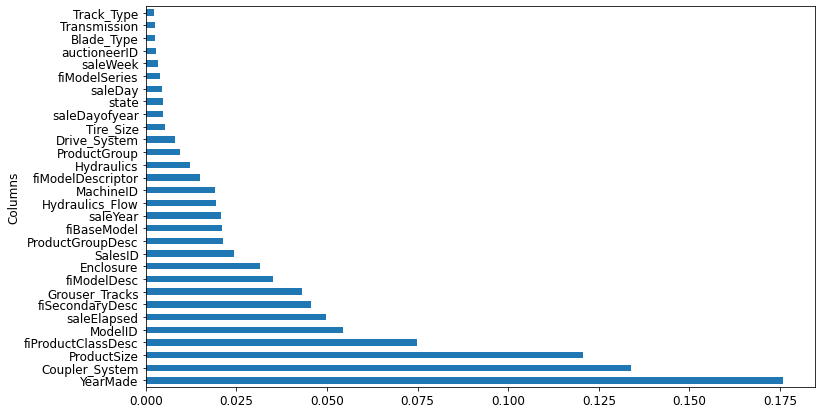

In [29]:
# Plotting my fi's.
def plot_fi(fi_df):
  return fi_df.plot("Columns", "Feat_Imps", "barh", figsize=(12,7), legend=False)

# Plots top 30 most important features of the model.
plot_fi(fi[:30])

In [30]:
# Taking out values that don't have hogh enough feature importances.
cols_to_keep = fi[fi["Feat_Imps"]>0.005].Columns
print(f"Length of columns being kept is {len(cols_to_keep)}")

# Reducing size of independant vars:
xs_imp = xs[cols_to_keep]
valid_xs_imp = valid_xs[cols_to_keep]

# Retraining the model with reduced columns.
m_rf_imp = rf(xs_imp, y)

# Checking train and validation errors.
m_rmse(m_rf_imp, xs_imp, y), m_rmse(m_rf_imp, valid_xs_imp, valid_y)

Length of columns being kept is 21


(0.181029, 0.230686)

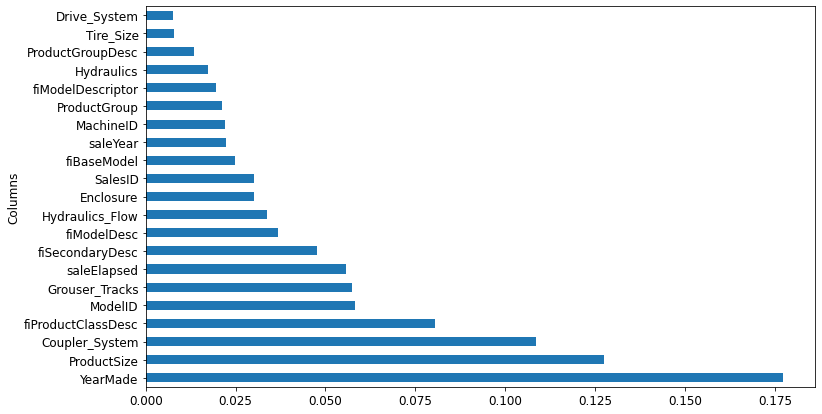

In [31]:
# Plotting feature importances with reduced size of cols.
fi_imp = rf_feat_imps(m_rf_imp, xs_imp)
plot_fi(fi_imp)
# Chart is much easier to interpret.

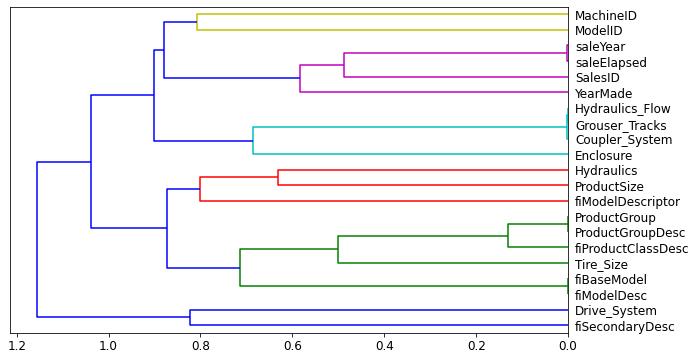

In [32]:
# Partial dependance plots and removing redundant features.

# Cluster plot of relations of variables.
cluster_columns(xs_imp)
 
# Most closely related cols are the ones joined late on the right of the cluster_columns()

In [33]:
# Getting OOB_score for each value in xs_imp by creating quick rf.
def get_oob(xs, dep_var=y, n_estimators=45, max_samples=50000, max_features=0.5, min_samples_leaf=15):
    m_rf_oob = RandomForestRegressor(
        n_estimators=n_estimators, n_jobs=-1,
        oob_score=True, max_samples=max_samples,
        max_features=max_features, min_samples_leaf=min_samples_leaf
        )
    m_rf_oob.fit(xs, y)
    return m_rf_oob.oob_score_

In [34]:
#get_oob(xs_imp)
# Getting oob for each value in xs_imp

# Look for the tightest alligned pairs and drop the value with a higher oob score.
# Check the effect of this on the model's performance.
{c:get_oob(xs_imp.drop(c, axis=1)) for c in xs_imp.columns if c.startswith(("saleE", "fiBase", "fiModel", "ProductGroup", "Grouser", "Coupler", "Hydraulics_", "saleY"))}

{'Coupler_System': 0.8772935193622211,
 'Grouser_Tracks': 0.8777090971985888,
 'Hydraulics_Flow': 0.8769602402145099,
 'ProductGroup': 0.8780365849992638,
 'ProductGroupDesc': 0.8769770653092022,
 'fiBaseModel': 0.8760172328726169,
 'fiModelDesc': 0.8758959079900481,
 'fiModelDescriptor': 0.8768208892035094,
 'saleElapsed': 0.87209466557463,
 'saleYear': 0.8774512944125828}

In [35]:
# These are the higher oob_scores_ for each pair (or third) of redundant variables.
redundant_cols = ['fiBaseModel', 'ProductGroupDesc', 'Grouser_Tracks', 'saleYear']
get_oob(xs_imp.drop(redundant_cols, axis=1)) # This is much lower than before so lets make this final.

0.8744259666023004

In [36]:
xs_final = xs_imp.drop(redundant_cols, axis=1)
valid_xs_final = valid_xs_imp.drop(redundant_cols, axis=1)

save_pickle(path/"xs_final.pkl", xs_final)
save_pickle(path/"valid_xs_final.pkl", valid_xs_final)

"""
# This is to get back our model after pickling.
xs_final = load_pickle(path/'xs_final.pkl')
valid_xs_final = load_pickle(path/'valid_xs_final.pkl')
"""

# Checking if the overall error hasnt changed much.
m_rf_fin = rf(xs_final, y)

print(f"Valid RMSLE: {m_rmse(m_rf_fin, valid_xs_final, valid_y)}\n"
      f"Train RMSLE: {m_rmse(m_rf_fin, xs_final, y)}\n")


Valid RMSLE: 0.232221
Train RMSLE: 0.183056



([<matplotlib.axis.YTick at 0x7fe7bd55f390>,
 [Text(0, 0, '#na#'),
  Text(0, 0, 'Large'),
  Text(0, 0, 'Large / Medium'),
  Text(0, 0, 'Medium'),
  Text(0, 0, 'Small'),
  Text(0, 0, 'Mini'),
  Text(0, 0, 'Compact')])

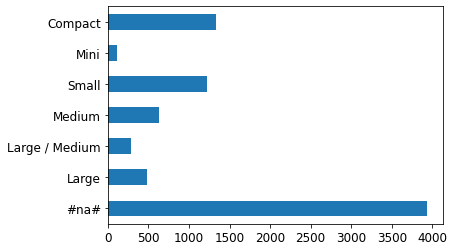

In [37]:
# Partial dependance plots. 
# Plotting the value_counts of the 3 highest feature importance cols.

# ProductSize
p_size = valid_xs_final["ProductSize"].value_counts(sort=False).plot.barh()
c = to.classes["ProductSize"] # Labels for yticks method
plt.yticks(range(len(c)), c)

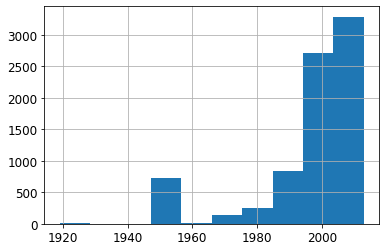

In [38]:
# YearMade
ax = valid_xs_final["YearMade"].hist()

([<matplotlib.axis.YTick at 0x7fe7be168a90>,
 [Text(0, 0, '#na#'), Text(0, 0, 'None or Unspecified'), Text(0, 0, 'Yes')])

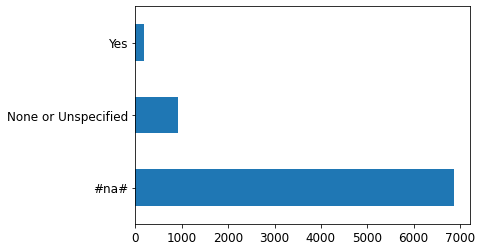

In [39]:
# Coupler_System (this is categorical so I'l plot a bar)
p_size = valid_xs_final["Coupler_System"].value_counts(sort=False).plot.barh()
c = to.classes["Coupler_System"] # Labels for yticks method
plt.yticks(range(len(c)), c)

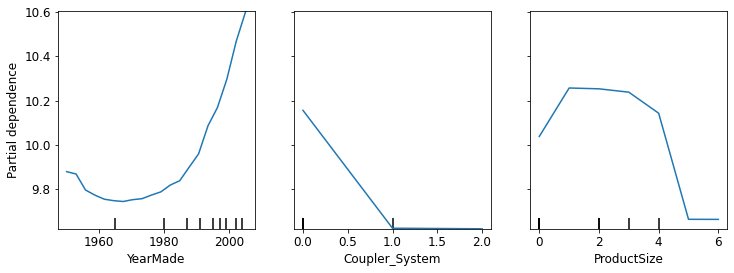

In [40]:
# Plotting partial dependance based on 3 most important cols
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12,4))
plot_partial_dependence(m_rf_fin, xs_final, ["YearMade", "Coupler_System", "ProductSize"],
                        grid_resolution=20, ax=ax)
# X-axis are meant to be levels of the independent variables in question.
# Next time plot partial dependencies for each column. Check for data leakage of they don't make sense in practice.
# As the sale_column is a logarithm, any linear relationships here are actually exponentials.

In [41]:
# Tree interpretations.
# Ignoring warnings to do with trees.
import warnings
warnings.simplefilter("ignore", FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

# Selecting a subset of rows for analysis.
rows = valid_xs_final.iloc[:10]
prediction,bias,contributions = treeinterpreter.predict(m_rf_fin, rows.values)

# If I have the time I will create a for loop for these.
print(f"Prediction: {prediction[0]} \nBias: {bias[0]} \nSum_of_Contributions: {contributions[0].sum()}")

Prediction: [10.01432091] 
Bias: 10.104918659942735 
Sum_of_Contributions: -0.09059774720049935


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

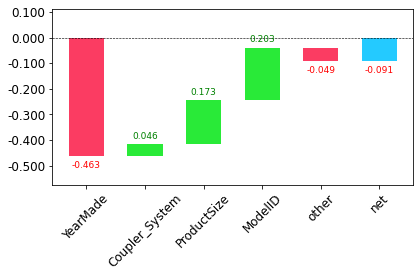

In [42]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08,
          rotation_value=45, formatting="{:,.3f}")

In [43]:
# Making model resilient over time.

# Concating train and valid sets and creating new rf.
df_domain = pd.concat([xs_final, valid_xs_final])
is_valid = array([0]*len(xs_final) + [1]*len(valid_xs_final))

# Checking if data exists in the validation set or not, using an rf.
# This shows which columns differ the most between valid and train sets.
rf_domain = rf(df_domain, is_valid)
rf_feat_imps(rf_domain, df_domain)[:6]

,Columns,Feat_Imps
5,saleElapsed,0.894509
9,SalesID,0.079597
11,MachineID,0.021862
4,ModelID,0.000763
8,Enclosure,0.000604
16,Tire_Size,0.000522


In [44]:
# Taking the 3 highest fi's out in turn and comparing error to original model.
for c in ("saleElapsed", "SalesID", "MachineID"):
  m = rf(xs_final.drop(c, axis=1), y)
  error = m_rmse(m, valid_xs_final.drop(c, axis=1), valid_y)
  print(f"{c}: {error}")

print(f"Original Error: {m_rmse(m_rf_fin, valid_xs_final, valid_y)}")
# Better to remove Machine and Sales ID.

saleElapsed: 0.234451
SalesID: 0.230346
MachineID: 0.230498
Original Error: 0.232221


In [45]:
time_vars_2drop = ["SalesID", "MachineID"]
xs_final_time = xs_final.drop(time_vars_2drop, axis=1)
valid_xs_final_time = valid_xs_final.drop(time_vars_2drop, axis=1)

# Checking model error after doing this.
m_rf_time = rf(xs_final_time, y)
# Checking new errors.
m_rmse(m_rf_time, valid_xs_final_time, valid_y)


0.22917

In [46]:
# Creating a filter and new model using only relevant data.
filter1 = xs["saleYear"]>2004
filter2 = valid_xs["saleYear"]>2004
xs_filtered = xs_final_time[filter1]
valid_xs_filtered = valid_xs_final_time[filter2]

# New model
m_rf_filt = rf(xs_filtered, y[filter1])

# Checking new errors.
rf_error = m_rmse(m_rf_filt, valid_xs_filtered, valid_y[filter2])
# Error is lower!

rf_error

0.229697

In [47]:
# Using a neural network. 
# Use the same pre-processing.
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes_ordered, ordered=True, inplace=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

#df_nn["ProductSize"].value_counts()

In [48]:
# NOtE: always make rf first, then utilise procs on nn.
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

# Making embeddings: (max_card needs to be high for creating embs. If there are over 9k levels, its not categorical)
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)
procs_nn = [Categorify, FillMissing, Normalize] # Have to normalise embeddings for nn.

# Checking cardinality rule was obeyed.
df_nn_final[cat_nn].nunique()
# It was obeyed, but I wanna remove one of the high cardinality variables to improve processing speed.

YearMade                73
Coupler_System           2
ProductSize              6
fiProductClassDesc      74
ModelID               5281
fiSecondaryDesc        177
fiModelDesc           5059
Enclosure                6
Hydraulics_Flow          3
fiModelDescriptor      140
Hydraulics              12
ProductGroup             6
Drive_System             4
Tire_Size               17
dtype: int64

In [49]:
# Removing one of the high cardinality features to make creating embeddings smoother for the NN.
xs_filtered2 = xs_filtered.drop('fiModelDescriptor', axis=1)
valid_xs_filtered2 = valid_xs_filtered.drop('fiModelDescriptor', axis=1)
m2 = rf(xs_filtered2, y[filter1])

# Creating errors
m_rmse(m2, xs_filtered2, y[filter1]), m_rmse(m2, valid_xs_filtered2, valid_y[filter2])
# As there is an improvement in the error, I'll remove the value.
#cat_nn.remove("fiModelDescriptor")

(0.176614, 0.230039)

In [50]:
# Creating tabular pandas.
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn, y_names=dep_var, splits=splits)

# Creating a dataloaders.
dls = to_nn.dataloaders(bs=1024)

In [51]:
# Checking the range of the y values to make min and max values for y_range param.
y = to.train.y
y.min(), y.max()

(8.465899467468262, 11.863582611083984)

SuggestedLRs(lr_min=0.002754228748381138, lr_steep=0.00019054606673307717)

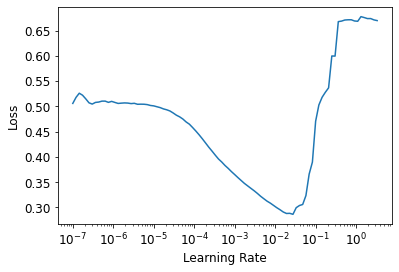

In [52]:
# Creating the nn.
learn = tabular_learner(dls, layers=[500,250], n_out=1, y_range=(8,12), loss_func=F.mse_loss)
learn.lr_find()

In [53]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.069093,0.060533,00:06
1,0.055707,0.056260,00:06
2,0.048655,0.056607,00:06
3,0.043830,0.051064,00:06
4,0.040791,0.050969,00:06


In [54]:
predictions_nn,targets = learn.get_preds()

# Computing mse loss on nn values.
nn_error = rmse(predictions_nn, targets)

# The error is lower than with the rf alone!
nn_error, rf_error

(0.225762, 0.229697)

In [56]:
# Creating an ensemble.
rf_preds = m_rf_filt.predict(valid_xs_filtered)
ensembles_preds = (to_np(predictions_nn.squeeze()) + rf_preds)/2 # Averaging the rf and nn preictions.

# Checking error of ensemble and comparing to other errors.
ensemble_error = rmse(ensembles_preds, valid_y)

ensemble_error, nn_error, rf_error
# Ensemble error is the lowest!

(0.222647, 0.225762, 0.229697)

In [71]:
# Using embeddings with the random forest
def embed_features(learner, xs):
    xs = xs.copy()
    for i, feature in enumerate(learn.dls.cat_names): # Enumerates the names of the categories and indexes trhought them
        emb = learner.model.embeds[i].cpu() # Puts the embeddings on the cpu()
        # Creates a dataframe of embeddings for each feature.
        new_feat = pd.DataFrame(emb(tensor(xs[feature], dtype=torch.int64)), index=xs.index, columns=[f'{feature}_{j}' for j in range(emb.embedding_dim)])
        # Deletes the old features and concatenates embedings together.
        xs.drop(columns=feature, inplace=True)
        xs = xs.join(new_feat)
    return xs

train_xs_emb = embed_features(learn, learn.dls.train.xs)
valid_xs_emb = embed_features(learn, learn.dls.valid.xs)


# Rf model madeby using embeddings.
m_rf_emb = rf(train_xs_emb, y)

In [72]:
# emb error.
emb_error = m_rmse(m_rf_emb, valid_xs_emb, valid_y)

emb_error
# Emb error ended up being higher than ensemble and nn error but lowe that a normal rf's error.

0.228314

In [ ]:

# Doing a random forest from scratch (to see how it works-this part of my code is copied!)

